---
title: "Too Young to Die: Exposing Child Mortality"
subtitle: "Analyzing Global Patterns and the Fight to Save Young Lives"
author: "Veera Venkata Sri Sai Manoj Amajala"
date: "2025-04-26"
format:
  html:
    toc: true
    toc-depth: 3
    toc-location: right
    theme: cosmo
    fontsize: 1.1em
    linestretch: 1.7
    embed-resources: true
    code-fold: true
execute:
    echo: true
    warning: false
    message: false
---


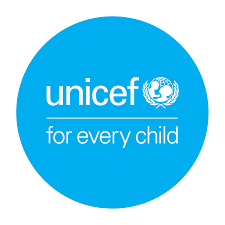

## 📚**1. Introduction**

Child mortality remains a profound indicator of public health and social progress, reflecting the living conditions, healthcare access, and overall well-being of the youngest members of society. This report will apply data analysis and visualization techniques to explore global trends in child deaths among those aged 1 to 4 years, highlighting the persistent challenges and disparities that exist across regions and income groups.

The datasets utilized in this report include unicef_indicator_1.csv , which provides detailed data on mortality rates for children aged 1-4 years, and unicef_metadata.csv , offering essential contextual information such as GDP, healthcare expenditure, life expectancy, and education levels.

This report seeks to shed light on the urgency of reducing child mortality and to advocate for targeted, evidence-based interventions that can save millions of young lives and foster healthier, more resilient societies.

## 🚨 **2. Where the Risk is Greatest?**
### 🗺  **Mapping Child Deaths Around the World in 2020**

*The choropleth map provides a clear visual representation of child mortality rates (aged 1-4 years) across different countries. By adjusting for population size, this approach reveals where children face the greatest relative risk of dying-uncovering patterns that raw numbers alone may obscure.*

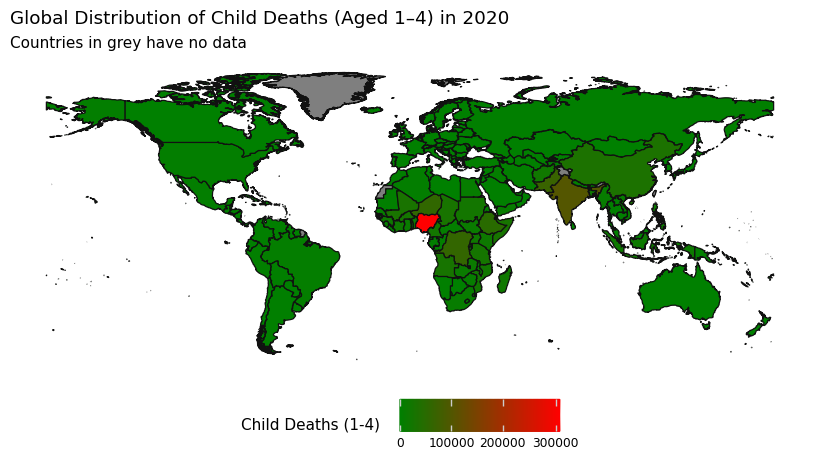

In [1]:
import polars as pl
import geopandas as gp
from plotnine import *
unicef_indicator1= pl.read_csv("/content/cleaned_unicef_indicator.csv")
#filter to specific year
filtered_unicef_indicator1 = (unicef_indicator1
                             .filter((pl.col("time_period") == 2020),
                              (pl.col("sex")== "Total"),
                               (pl.col("indicator") == "Child deaths (aged 1-4 years)")
                               )
                             .select(["country","obs_value","alpha_3_code"])
                             )
#MERGING
shape_world = gp.read_file("https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/shp")
shape_world = shape_world.rename(columns={"name": "country"})
filtered_unicef_indicator1_pd = filtered_unicef_indicator1.to_pandas()
merged_data = shape_world.merge(filtered_unicef_indicator1_pd, left_on="iso3",right_on="alpha_3_code", how="left")

#PLOTTING

map_plot =(
    ggplot(data=merged_data)
  + aes(fill="obs_value")
  + geom_map()
  + scale_fill_gradient(name="Child Deaths (1-4)", low="green", high="red")
  + labs(
      title="Global Distribution of Child Deaths (Aged 1–4) in 2020",
      subtitle="Countries in grey have no data",
      x="Longitude",
      y="Latitude",
      fill="obs_value"
  )
  + coord_fixed()
  + theme_void()
  +theme(legend_position="bottom", figure_size=(8 ,8 ))
)
map_plot.draw()

 Using the most recent UNICEF data, merged child death figures with population estimates and country codes to ensure accurate comparisons.

 The map shows stark contrasts: nations grappling with conflict, poverty, and inadequate healthcare infrastructure exhibit the highest mortality rates. Meanwhile, countries with well-established healthcare systems, widespread immunization, and strong maternal support services report significantly lower child death rates.

 This normalized view emphasizes the uneven distribution of child health outcomes globally. It highlights the urgency of tailored public health interventions in regions most affected and underscores the need for global efforts to close these survival gaps and ensure that every child, regardless of geography, has a fair chance at life.

## **3. Where Childhood Ends Too Soon?**
### 📊 **The 20 Countries Facing the Highest Child Mortality Rates in 2020**

*Using the most recent data on child deaths (aged under 5 years), we identified the 20 countries with the highest recorded mortality. This analysis offers insight into where child health crises are most concentrated globally. To explore potential gender disparities, we also segmented the data by sex, comparing death counts between Male and Female.*


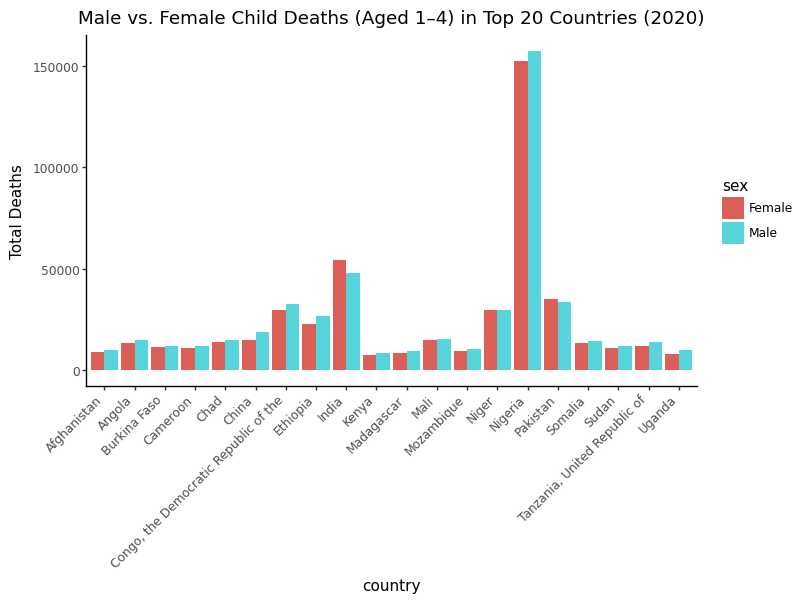

In [2]:
import polars as pl
from plotnine import *
unicef_indicator1= pl.read_csv("/content/cleaned_unicef_indicator.csv")
filtered_unicef_indicator2 = (unicef_indicator1
                             .filter((pl.col("time_period") == 2020),
                              (pl.col("sex").is_in(["Male","Female"])),
                               (pl.col("indicator") == "Child deaths (aged 1-4 years)")
                               )
                             .select(["country","sex","obs_value"])
                             )

total = (
    filtered_unicef_indicator2
    .group_by("country")
    .agg(pl.col("obs_value").sum().alias("total_deaths"))
    .sort("total_deaths", descending=True)
    .head(20)
)


top_countries = total["country"].to_list()


top10 = (
    filtered_unicef_indicator2
    .filter(pl.col("country").is_in(top_countries))
)

df_plot = top10.to_pandas()


grouped_bar_chart = (
    ggplot(df_plot, aes(x="country", y="obs_value", fill="sex"))
    + geom_col(position="dodge") +
    labs(
        title="Male vs. Female Child Deaths (Aged 1–4) in Top 20 Countries (2020)",
        x="country",
        y="Total Deaths",
        fill="sex"
    )
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    +theme(legend_position='right', figure_size=(8 ,6 ))
)


grouped_bar_chart.draw()



Our findings reveal that these top 20 countries account for a large proportion of global child deaths, pointing to deep-rooted challenges in specific regions. Often, Male exhibit slightly higher mortality rates than Female -a trend seen in many global studies- though this is not consistent across all countries.

These outcomes are shaped by a range of systemic issues, including persistent poverty, political instability, limited access to medical care, and inadequate sanitation infrastructure. By spotlighting these countries and the gender breakdowns within them, the data calls for urgent, targeted responses to reduce child mortality and address broader public health inequalities.

## 🏆 **4. Rays of Progress**
### 📊 **The World’s Lowest Child Death Rates (2020)**

*The lollipop chart below illustrates child mortality rates for the 30 countries with the lowest rates in a particular year, showcasing nations that have made significant strides in improving child health. These countries benefit from strong healthcare systems, widespread immunization, improved nutrition, and solid infrastructure for clean water and sanitation, resulting in higher child survival rates.*

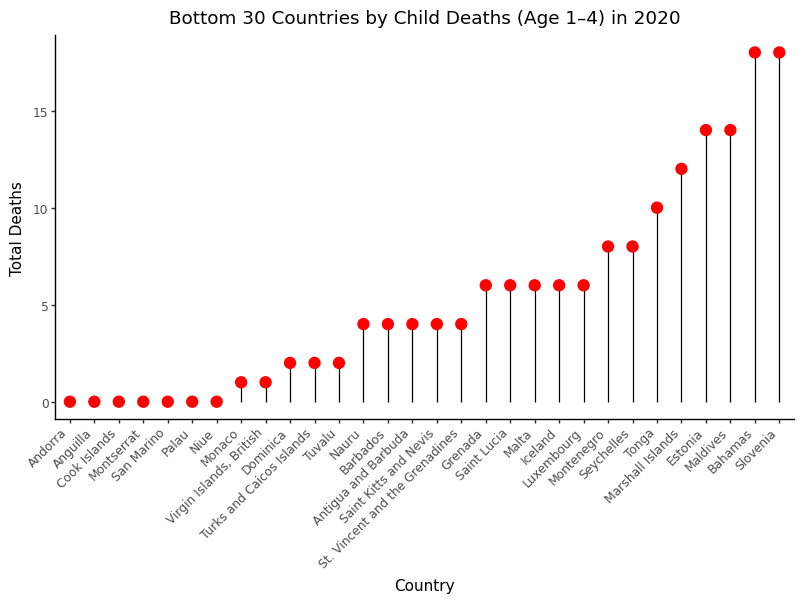

In [3]:
import polars as pl
from plotnine import *


df = pl.read_csv("/content/cleaned_unicef_indicator.csv")


latest_year = df.select(pl.col("time_period").max()).item()


df_latest = (
    df
    .filter(pl.col("time_period") == 2020)
    .group_by("country")
    .agg(pl.col("obs_value").sum().alias("total_deaths"))
    .sort("total_deaths", descending=True)
    .tail(30)  #bottom 30 countries
)


df_pandas = df_latest.to_pandas()


lollipop = (
    ggplot(df_pandas, aes(x="total_deaths", y="reorder(country, total_deaths)"))
    + geom_segment(aes(x=0, xend="total_deaths", y="country", yend="country"), color="BLACK")
    + geom_point(size=4, color='RED')
    + coord_flip()
    + labs(
        title="Bottom 30 Countries by Child Deaths (Age 1–4) in 2020",
        x="Total Deaths", y="Country"
    )
    + theme_classic()
    + theme(figure_size=(8 ,6 ))
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

lollipop.draw()



Many of these nations are located in Europe, North America, and East Asia, regions with long-term investments in healthcare and economic development.

Some island nations with smaller populations also feature on the list, which may contribute to their lower child mortality rates. The smaller populations allow for more accessible and effective healthcare interventions. Continued focus on healthcare access, education, and nutrition is critical to ensuring every child, regardless of location, has the opportunity to thrive.

## **5. Closing the Gap?**
### 📈 **5.1 Tracking Male ♂ and Female ♀ Child Deaths**

*This time series visualization presents global child deaths (aged 1-4 years) over time, separated by sex. By tracking mortality for boys and girls from 1960 onward, the chart reveals both long-term progress and persistent gender patterns in child survival.*

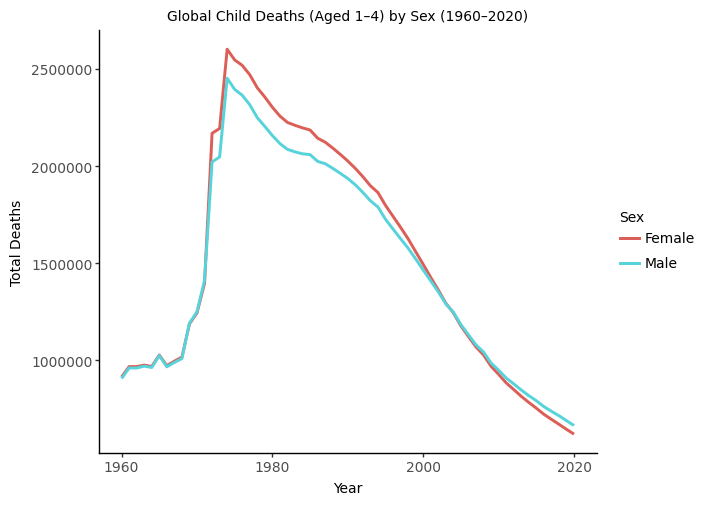

In [4]:
import polars as pl
from plotnine import *
unicef_indicator1= pl.read_csv("/content/cleaned_unicef_indicator.csv")
filtered_unicef_indicator3 = (unicef_indicator1
                             .filter((pl.col("time_period") >= 1960),
                                     (pl.col("time_period") <= 2020),
                              (pl.col("sex").is_in(["Male","Female"])),
                               (pl.col("indicator") == "Child deaths (aged 1-4 years)")
                               )
                             .select(["time_period","sex","obs_value"])
                             )

grouped_year = (
filtered_unicef_indicator3
                 .group_by(["time_period","sex"])
                 .agg(pl.col("obs_value").sum().alias("total_deaths"))
                 .sort(["time_period","sex"])
                 )

data_plot = grouped_year.to_pandas()
time_series_chart = (
    ggplot(data_plot, aes(x='time_period', y='total_deaths', color='sex'))
    + geom_line(size=1.2)
    + labs(
        title="Global Child Deaths (Aged 1–4) by Sex (1960–2020)",
        x="Year",
        y="Total Deaths",
        color="Sex"
    )
    + theme_classic()
  + theme(text=element_text(size=10))
  +theme(legend_position='right', figure_size=(7,5))
)

time_series_chart.draw()

Over the years, child mortality rates for both male and female have shown a significant decline, reflecting the success of global health initiatives such as expanded vaccination programs, improved maternal care, and better nutrition. These efforts have played a key role in reducing preventable child deaths and enhancing overall child health worldwide.

Ultimately, this chart highlights the importance of continued investment in early childhood healthcare. Ensuring equal access to life-saving interventions for both male and female is crucial for sustaining this progress and achieving further reductions in child mortality rates globally, fostering healthier futures for all children.

### 📉 **5.2 A Gender-Based Scatterplot Analysis with Trendlines**

*This scatterplot explores global child deaths (aged 1-4 years) over time, distinguished by sex. Each point represents a year observation, with child death counts on the y-axis and year on the x-axis. By coloring the points based on sex and fitting separate regression lines for male and female, we visualize long-term gender-specific trends in mortality.*



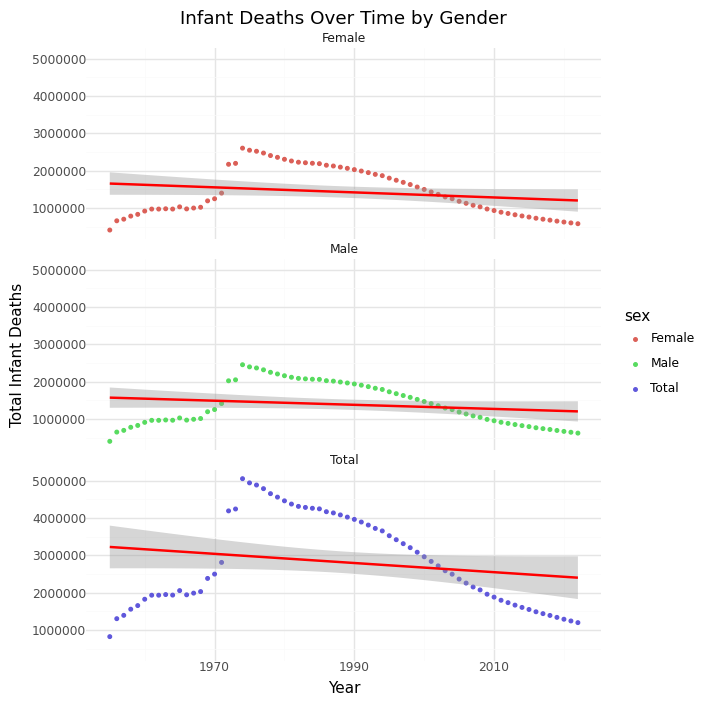

In [5]:
import polars as pl
from plotnine import *


df = pl.read_csv("/content/cleaned_unicef_indicator.csv")


df_filtered = (
    df.filter(
        (pl.col("indicator") == "Child deaths (aged 1-4 years)") ,
        (pl.col("sex").is_in(["Female", "Male","Total"]))
    )
    .select(["country", "time_period", "sex", "obs_value"])
)


df_grouped = (
    df_filtered
    .group_by(["time_period", "sex"])
    .agg(pl.sum("obs_value").alias("total_deaths"))
    .sort(["sex", "time_period"])
    .to_pandas()
)


plot = (
    ggplot(df_grouped)
    + aes(x="time_period", y="total_deaths",color="sex")
    + geom_point(size= 1)
    + geom_smooth(method="lm", color="red")
    + facet_wrap("~sex",ncol=1)
    + labs(
        title="Infant Deaths Over Time by Gender",
        x="Year",
        y="Total Infant Deaths"
    )
    + theme_minimal()
    + theme(legend_position='right', figure_size=(7,7))
)

plot.draw()



### Trends Observed from the Scatterplot with Regression Lines


*   **Downward Trends**: Both male and female mortality rates have steadily declined, illustrating the positive impact of global child health initiatives.

*  **Consistent Gender Gap**: Boys have consistently higher mortality rates than girls in most years, a trend supported by biological and demographic studies. Despite this gap, both sexes benefit from overall health improvements, as shown by the similar downward slopes.

* **Clear Divergence**: The separate regression lines for each sex highlight nuanced differences in the pace and consistency of mortality reduction, emphasizing the need for a gender-aware approach in policy and intervention.


## 🆚**6. Trends in Child Deaths vs. Total Population Over Time**

*The time series chart compares child deaths with total population size over time, showing the relationship between these two variables. Initially, as the population grows, child deaths also rise. However, over time, child mortality begins to decline despite population growth, reflecting the success of global health initiatives such as vaccination, better maternal care, and improved nutrition.*


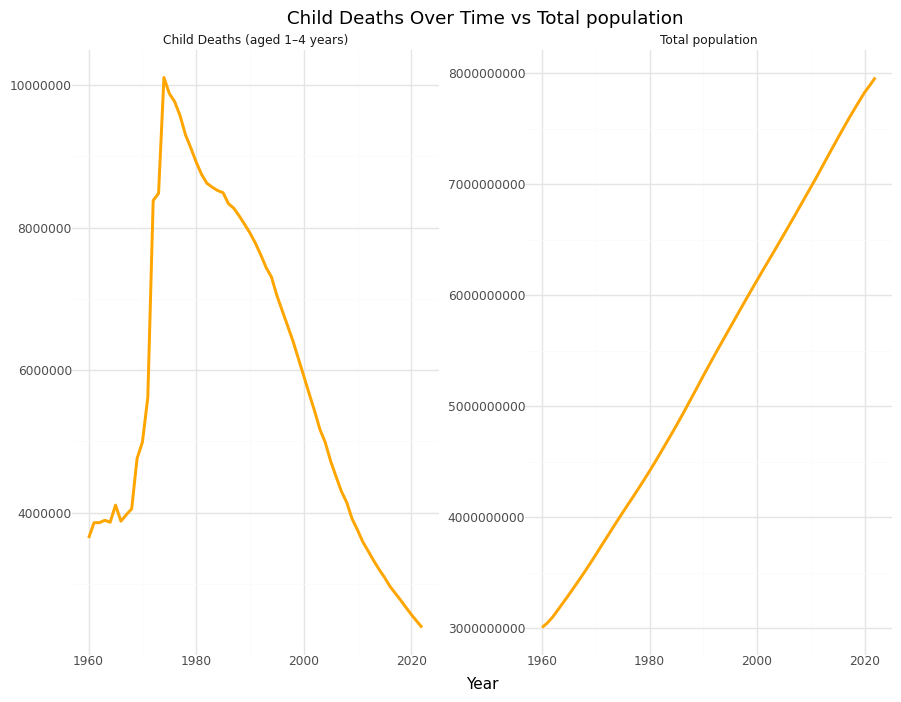

In [21]:
import polars as pl
import pandas as pd
from plotnine import *


indicator_df = pl.read_csv("/content/cleaned_unicef_indicator.csv")
metadata_df = pl.read_csv("/content/cleaned_unicef_metadata.csv")


child_deaths = (
    indicator_df

    .group_by(pl.col("time_period"))
    .agg(pl.col("obs_value").sum().alias("total_child_deaths"))
)



pop_data = (
    metadata_df
    .filter(pl.col("population_total").is_not_null())
    .with_columns(pl.col("year").alias("time_period"))
    .group_by("time_period")
    .agg(pl.col("population_total").sum().alias("Total population"))
)


combined_df = child_deaths.join(pop_data, on="time_period", how="inner").sort("time_period")


df = combined_df.to_pandas()


df_long = pd.melt(
    df,
    id_vars=["time_period"],
    value_vars=["total_child_deaths", "Total population"],
    var_name="variable",
    value_name="value"
)


df_long["variable"] = df_long["variable"].map({
    "total_child_deaths": "Child Deaths (aged 1–4 years)",
    "Total population": "Total population"
})


plot = (
    ggplot(df_long, aes(x="time_period", y="value"))
    + geom_line(size=1.2, color="orange")
    + facet_wrap("~variable", scales="free_y")
    + labs(title=" Child Deaths Over Time vs Total population",
           x="Year",
           y="")
    + theme_minimal()
    + theme( figure_size=(9,7))
)

plot.draw()


The chart highlights periods of rapid decline in child deaths, demonstrating the impact of health interventions, while also pointing to occasional increases due to crises or other challenges.

## **7. Progress 🚀and Pitfalls ⚠**
### **Tracking Child Mortality Across Nations**

*The time series analysis of child deaths across 10 randomly selected countries highlights important global health patterns.*

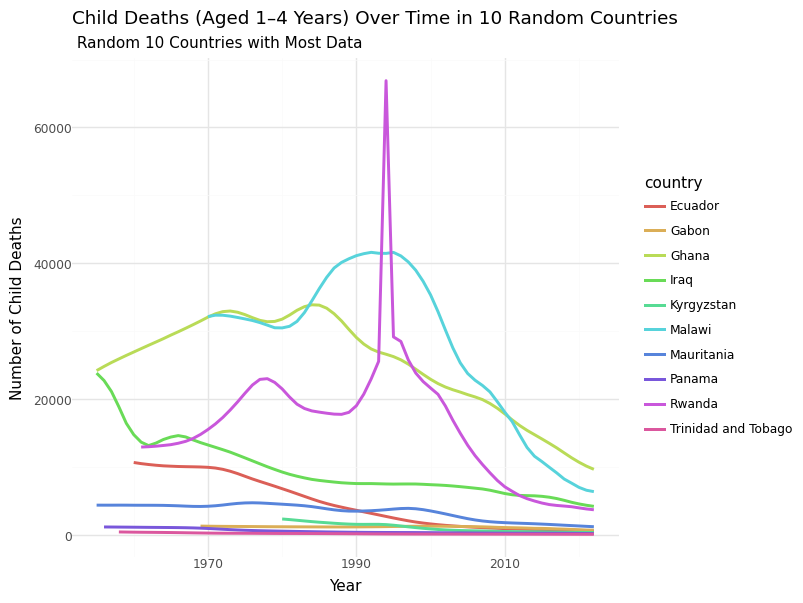

In [25]:
import polars as pl
from plotnine import *
import random


unicef_indicator1= pl.read_csv("/content/cleaned_unicef_indicator.csv")


filtered = (unicef_indicator1
            .filter(
    (pl.col("sex") == "Total") ,
    (pl.col("obs_value").is_not_null())
)
)

total = (
    filtered
    .group_by("country")
    .agg(pl.col("obs_value").sum().alias("total_deaths"))
    .sort("total_deaths", descending=True)

)
unique_countries = filtered.select("country").unique().to_series().to_list()
sampled_countries = random.sample(unique_countries, 10 )

random_10 = (
    filtered
    .filter(pl.col("country").is_in(sampled_countries))
)

df_plot = random_10.to_pandas()

plot = (
    ggplot(df_plot)
    + aes(x="time_period", y="obs_value", color="country" )
    + geom_line(size= 1.2)
    + labs(
        title="Child Deaths (Aged 1–4 Years) Over Time in 10 Random Countries",
        subtitle=" Random 10 Countries with Most Data",
        x="Year",
        y="Number of Child Deaths"
    )
    + theme_minimal()
    + theme(legend_position="right", figure_size=(8 ,6))
)


plot.draw()

In several nations, there's a clear and steady decline in mortality among children aged 1-4, often linked to better healthcare systems, increased vaccination coverage, improved nutrition, and sanitation. These positive trends suggest effective public health interventions and support from international organizations. However, not all countries follow the same path. Some show irregular patterns or little progress, likely influenced by socio-political instability, limited resources, or health emergencies such as epidemics. These fluctuations reveal the fragility of health systems in certain regions.

Overall, the chart reflects a mixed global picture-some countries are making significant progress, while others continue to struggle. This diversity in outcomes underscores the need for targeted, country-specific strategies. It reminds us that while global child mortality has improved overall, achieving equity in child survival remains a critical challenge that demands ongoing attention and investment.

## 🧠**Conclusion**

The analysis highlights that child mortality among ages 1-4 remains a significant global concern, particularly in low-income countries where healthcare access, nutrition, and sanitation are limited. Despite progress in some regions, disparities persist, demanding urgent action. Addressing these challenges is crucial to ensure that every child has the chance to survive and thrive.

## 💡**Recommendations**


1.  ***Strengthen healthcare systems,*** focusing on maternal and child health services.

2. ***Expand vaccination programs*** and improve access to essential medicines.

3. ***Invest in nutrition and clean water initiatives*** to combat preventable diseases.

4. ***Enhance data collection and monitoring*** to guide policies more effectively.

5. ***Promote education and community awareness*** to empower families with life-saving knowledge.



## 🌐**Source**
[UNICEF](https://www.unicef.org/)